In [1]:
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For data manipulation and IO
import seaborn as sns  # For advanced plotting

In [2]:
# Load the datasets from the cleaned Excel file.
datasets = pd.read_excel("FINAL-BDA-dataset.xlsx", sheet_name=None)

# This Excel file has three sheets:
df_translated = datasets["translated_dataset"]
df_original = datasets["original_dataset"]
df_bins = datasets["Bins"]

In [3]:
# Define a `total_enrolled` column as the sum of both semesters' enrolled units.
df_translated["total_enrolled"] = (
    df_translated["Curricular units 1st sem (enrolled)"]
    + df_translated["Curricular units 2nd sem (enrolled)"]
)

# Define a `total_approved` column as the sum of both semesters' approved units.
df_translated["total_approved"] = (
    df_translated["Curricular units 1st sem (approved)"]
    + df_translated["Curricular units 2nd sem (approved)"]
)

# Define an `approval_rate` column as the ratio of `total_approved` to `total_enrolled`.
df_translated["approval_rate"] = (
    df_translated["total_approved"] / df_translated["total_enrolled"]
)


# Define an `overall_grade` column as the arithmetic mean of both semesters' grades.
df_translated["overall_grade"] = df_translated[
    ["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]
].mean(axis="columns")

## Who is at risk of dropping early, based on 1st term data?


In [4]:
def boxplot(
    column: str, by: str = "Target", column_title: str | None = None, **kwargs
) -> plt.Axes:
    """
    Create a boxplot of a numeric column by Target (or other categorical column).

    Parameters
    ----------
    column : str
        Column name to plot on the y-axis.
    by : str, optional
        Column name to group by on the x-axis. (Default is "Target").
    column_title : str, optional
        Custom title for the y-axis and plot title. If None, a column title will be
        inferred. (Default is None)
    **kwargs
        Additional keyword arguments to pass to `sns.boxplot()`.

    Returns
    -------
    plt.Axes
        The `matplotlib` boxplot Axes object.
    """
    fig, ax = plt.subplots(figsize=(7, 4))
    # Order the boxplots by their medians.
    order = df_translated.groupby(by)[column].median().sort_values().index
    ax = sns.boxplot(
        x=by,
        y=column,
        data=df_translated,
        ax=ax,
        hue=by,
        order=order,
        hue_order=order,
        **kwargs,
    )

    # If there is no custom column title given...
    if not column_title:
        # ...one will be generated from the column name.
        column_title = column.replace("_", " ").title()

    ax.set_title(f"{column_title} by Outcome")
    ax.set_xlabel("")
    ax.set_ylabel(column_title)
    fig.tight_layout()
    return ax

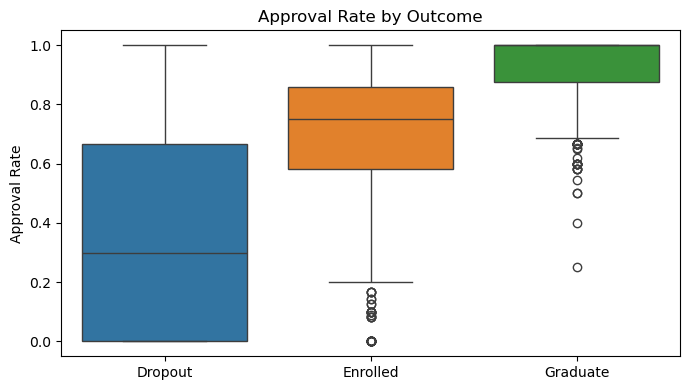

In [5]:
# Boxplot of approval rate by target outcome.
ax = boxplot("approval_rate")

In [6]:
# Get whatever color palette the first plot used.
patch_colors = [p.get_facecolor() for p in ax.patches]
labels = [t.get_text() for t in ax.get_xticklabels()]
palette = dict(zip(labels, patch_colors, strict=True))
palette

{'Dropout': (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1),
 'Enrolled': (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
 'Graduate': (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1)}

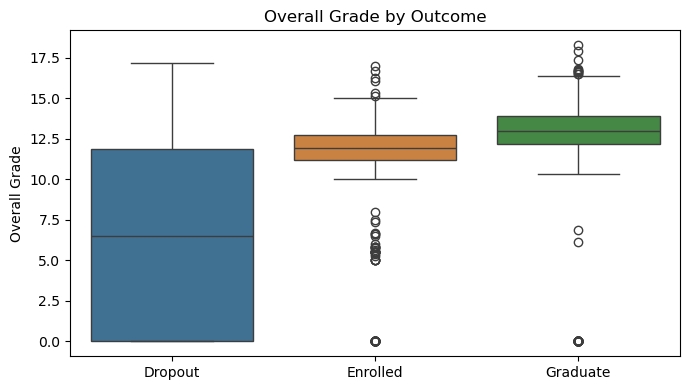

In [7]:
# Boxplot of overall grade by target outcome, using the same palette as the first plot.
ax = boxplot("overall_grade", palette=palette)

Text(0.5, 0, 'Overall Grade')

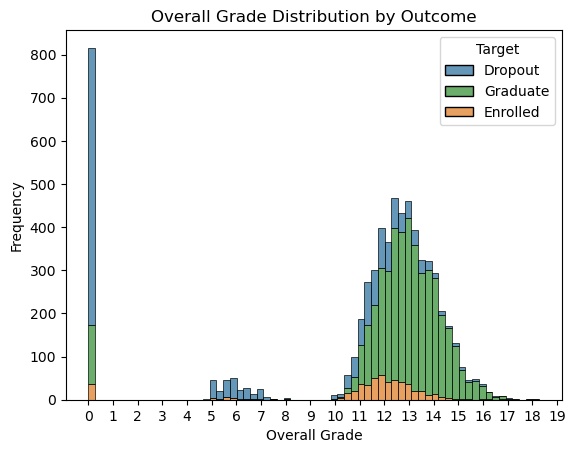

In [8]:
# Create a stacked bar chart of overall grade by target outcome.
# `sns.histplot` is better for stacked bar charts than `sns.countplot`.
ax = sns.histplot(
    data=df_translated,
    x="overall_grade",
    hue="Target",
    multiple="stack",
    palette=palette,
    stat="frequency",
)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Major ticks every 1 unit.
ax.set_title("Overall Grade Distribution by Outcome")
ax.set_xlabel("Overall Grade")

Text(0, 0.5, 'Total Enrolled')

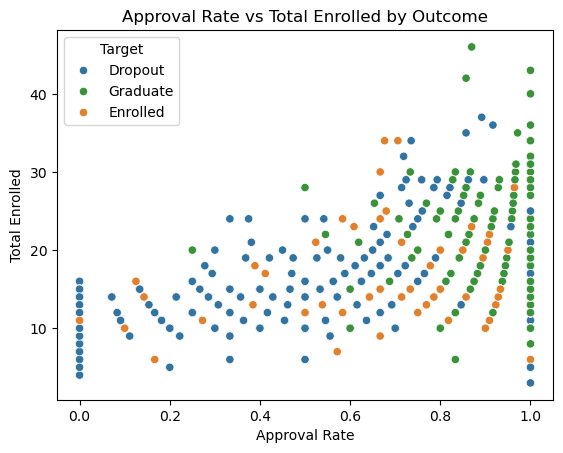

In [9]:
ax = sns.scatterplot(
    data=df_translated,
    x="approval_rate",
    y="total_enrolled",
    hue="Target",
    palette=palette,
)

ax.set_title("Approval Rate vs Total Enrolled by Outcome")
ax.set_xlabel("Approval Rate")
ax.set_ylabel("Total Enrolled")

## Are there equity gaps in outcomes by financial support / background?


In [10]:
# Preview some of the columns we'll be using...
df_translated[
    [
        "Scholarship holder",
        "Mother's qualification (binned)",
        "Father's qualification (binned)",
        "Target",
    ]
]

,Scholarship holder,Mother's qualification (binned),Father's qualification (binned),Target
0,No,Special Courses,Secondary Education,Dropout
1,No,Secondary Education,Higher Education,Graduate
2,No,Special Courses,Basic Education,Dropout
3,No,Special Courses,Basic Education,Graduate
4,No,Special Courses,Basic Education,Graduate
...,...,...,...,...
4419,No,Secondary Education,Secondary Education,Graduate
4420,No,Secondary Education,Secondary Education,Dropout
4421,Yes,Special Courses,Basic Education,Dropout
4422,Yes,Special Courses,Basic Education,Graduate


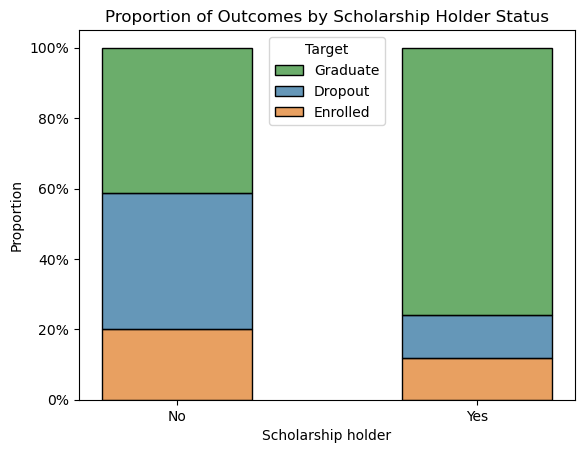

In [11]:
ax = sns.histplot(
    data=(
        df_translated.groupby("Scholarship holder")["Target"]
        .value_counts(normalize=True)  # Normalize to 100%
        .reset_index()
    ),
    x="Scholarship holder",
    weights="proportion",
    hue="Target",
    palette=palette,
    multiple="stack",
    discrete=True,
    shrink=0.5,  # Add spacing between bars (normal histplot has no gap).
)
ax.set_title("Proportion of Outcomes by Scholarship Holder Status")
ax.set_ylabel("Proportion")
ax.yaxis.set_major_formatter("{x:.0%}")  # Format y-axis as percentages.
ax.get_legend().set_loc("upper center")

Text(0, 0.5, 'Proportion of Dropouts')

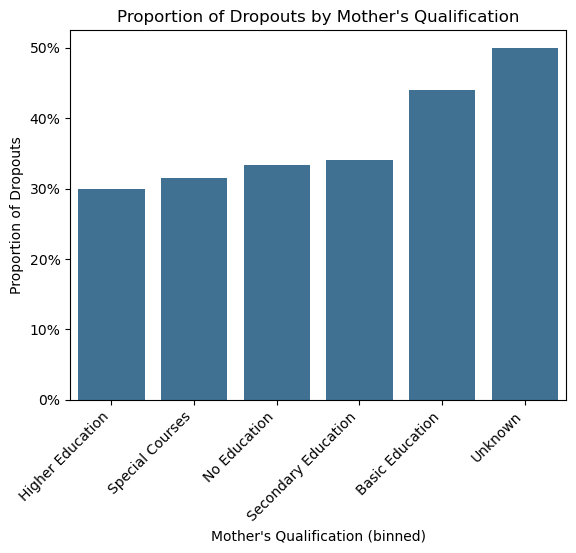

In [12]:
# Create a binary "is_dropout" column for easy aggregation.
df_translated["is_dropout"] = (df_translated["Target"] == "Dropout").astype(int)

# Calculate dropout rates by Mother's qualifications.
order = (
    df_translated.groupby("Mother's qualification (binned)")["is_dropout"]
    .mean()
    .sort_values()
    .index
)

ax = sns.barplot(
    data=df_translated,
    x="Mother's qualification (binned)",
    y="is_dropout",
    order=order,
    errorbar=None,
    color=palette["Dropout"],
)

for x_label in ax.get_xticklabels():
    # Shift each label and tilt 45 degrees so they fit on the page.
    x_label.set_ha("right")
    x_label.set_va("top")
    x_label.set_rotation(45)

ax.get_yaxis().set_major_formatter("{x:.0%}")  # Format y-axis as percentages.
ax.set_title("Proportion of Dropouts by Mother's Qualification")
ax.set_xlabel("Mother's Qualification (binned)")
ax.set_ylabel("Proportion of Dropouts")

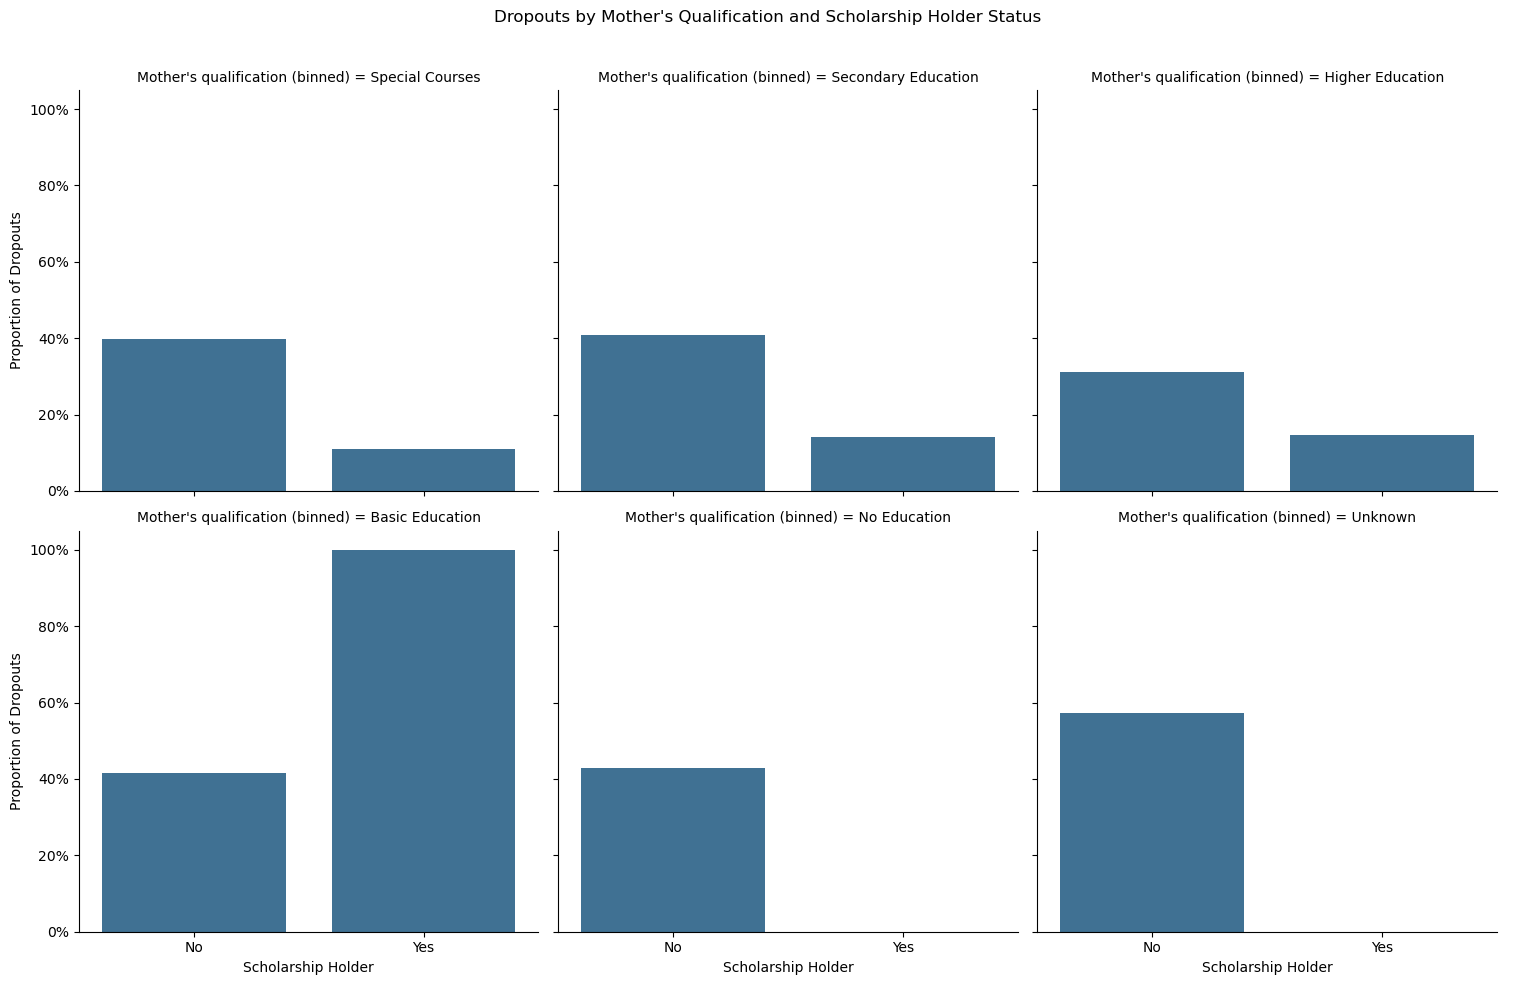

In [13]:
# Dropout rates by Mother's qualification and Scholarship holder status.
facets = sns.catplot(
    data=df_translated,
    x="Scholarship holder",
    y="is_dropout",
    col="Mother's qualification (binned)",
    kind="bar",
    col_wrap=3,
    errorbar=None,
    margin_titles=True,
    color=palette["Dropout"],
)

facets.set_axis_labels("Scholarship Holder", "Proportion of Dropouts")
facets.fig.subplots_adjust(top=0.9)
facets.fig.suptitle("Dropouts by Mother's Qualification and Scholarship Holder Status")
facets.axes[0].yaxis.set_major_formatter("{x:.0%}")  # Format y-axis as percentages.

## Which courses have the highest failure rates?

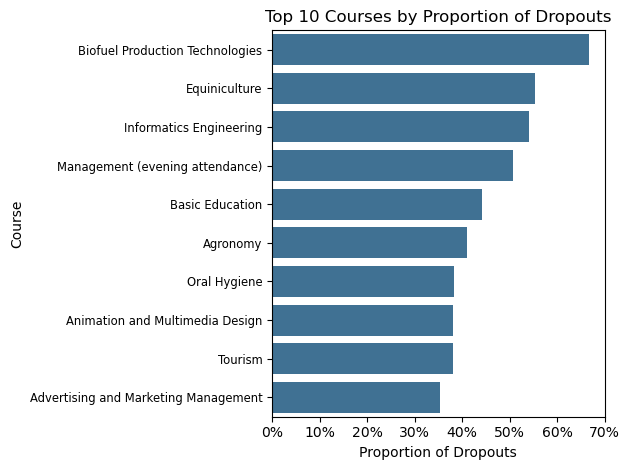

In [14]:
# Find the top 10 courses by dropout rate.
top_10_dropout_courses = (
    df_translated.groupby("Course")["is_dropout"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

ax = sns.barplot(
    top_10_dropout_courses,
    x="is_dropout",
    y="Course",
    color=palette["Dropout"],
    orient="h",  # Horizontal bar chart
)

for y_label in ax.get_yticklabels():
    # Y-labels are really long, so decrease the font size a little.
    y_label.set_fontsize("small")

ax.get_xaxis().set_major_formatter("{x:.0%}")  # Format x-axis as percentages.
ax.set_title("Top 10 Courses by Proportion of Dropouts")
ax.set_xlabel("Proportion of Dropouts")
plt.tight_layout()

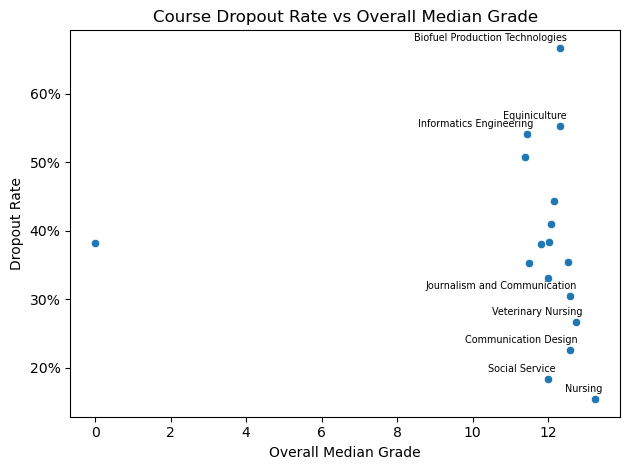

In [15]:
# Find the dropout rate and median overall grade for each course.
drops_by_course_median_grade = (
    df_translated.groupby("Course")
    .agg(
        **{
            "Dropout Rate": ("is_dropout", "mean"),  # Dropout rate - Mean
            "Overall Median Grade": ("overall_grade", "median"),  # Grade - Median
        },
    )
    .sort_values(by="Dropout Rate", ascending=False)
)

ax = sns.scatterplot(
    drops_by_course_median_grade, x="Overall Median Grade", y="Dropout Rate"
)
ax.set_title("Course Dropout Rate vs Overall Median Grade")

# Adding all the labels was too much. So, we'll just label the top 3 and bottom 5.
labels_df = pd.concat(
    [drops_by_course_median_grade.head(3), drops_by_course_median_grade.tail(5)]
)
for index, row in labels_df.iterrows():
    # Add an annotation for each labeled course.
    ax.annotate(
        index,
        (row["Overall Median Grade"], row["Dropout Rate"]),  # Real (x, y)
        textcoords="offset points",
        xytext=(5, 5),  # Offset (x, y)
        fontsize="x-small",
        ha="right",
    )
ax.get_yaxis().set_major_formatter("{x:.0%}")  # Format y-axis as percentages.
plt.tight_layout()

In [16]:
ct = df_translated.groupby("Course")["Target"].value_counts(normalize=True).unstack()

ct.map("{:03.0%}".format)  # Format as percentages with leading zeros.

Target,Dropout,Enrolled,Graduate
Course,,,
Advertising and Marketing Management,35%,18%,47%
Agronomy,41%,18%,41%
Animation and Multimedia Design,38%,17%,45%
Basic Education,44%,26%,30%
Biofuel Production Technologies,67%,25%,08%
Communication Design,23%,19%,59%
Equiniculture,55%,15%,30%
Informatics Engineering,54%,38%,08%
Journalism and Communication,31%,10%,59%


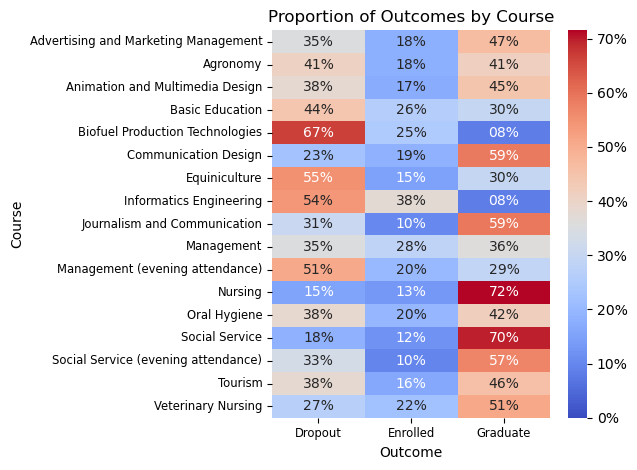

In [17]:
ax = sns.heatmap(
    ct,
    annot=True,
    fmt="03.0%",  # Format annotations as percentages with leading zeros.
    vmin=0,
    cmap="coolwarm",
    cbar_kws={"format": "{:.0%}".format},  # Format color bar as percentages.
)
ax.set_title("Proportion of Outcomes by Course")
for label in ax.get_yticklabels() + ax.get_xticklabels():
    # x and y labels are too large, so decrease the font size a little.
    label.set_fontsize("small")
ax.set_xlabel("Outcome")
plt.tight_layout()

Text(0.5, 0.98, 'Enrollment by Outcome for Top 10 Dropout Courses')

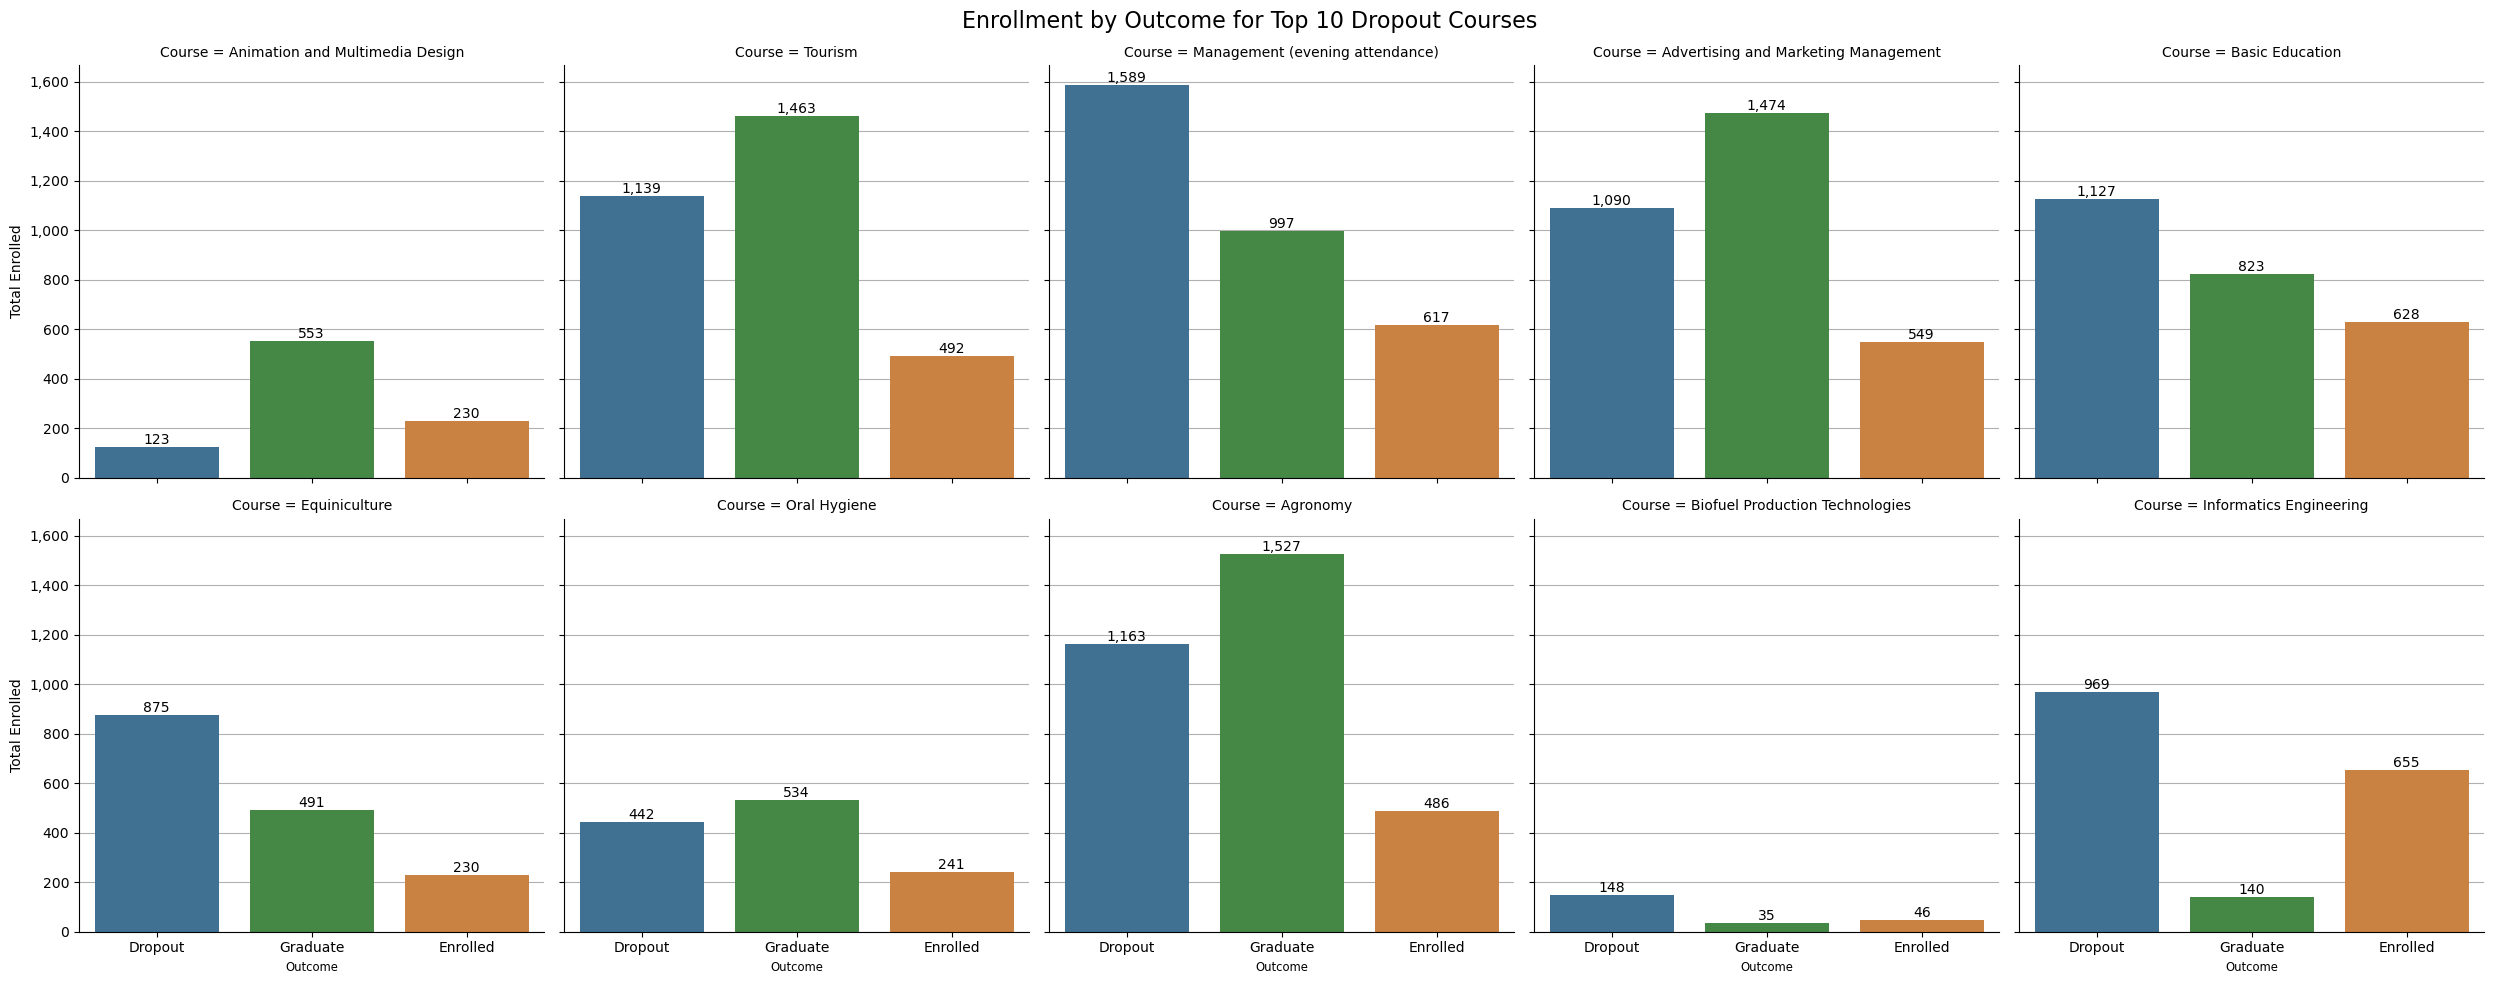

In [18]:
top_dropout_courses = top_10_dropout_courses["Course"]

facet_grid = sns.catplot(
    df_translated.query("Course in @top_dropout_courses"),
    kind="bar",
    x="Target",
    y="total_enrolled",
    col="Course",
    hue="Target",
    col_wrap=5,
    margin_titles=True,
    errorbar=None,
    estimator=sum,
    palette=palette,
)

facet_grid.set_axis_labels(x_var="Outcome", y_var="Total Enrolled")
facet_grid.set_xlabels(fontsize="small")

for subplot_axis in facet_grid.axes.flat:
    # For each subplot...
    # 1) Add y-axis grid lines.
    subplot_axis.yaxis.grid(True)
    for container in subplot_axis.containers:
        # 2) Add bar labels with thousand separators.
        subplot_axis.bar_label(container, fmt="{:,.0f}")
    # 3) Format y-axis with thousand separators.
    subplot_axis.yaxis.set_major_formatter("{x:,.0f}")
    # 4) Ensure grid lines are *behind* the bars.
    subplot_axis.set_axisbelow(True)

facet_grid.fig.subplots_adjust(top=0.925)
facet_grid.fig.suptitle("Enrollment by Outcome for Top 10 Dropout Courses", fontsize=16)